## Dependencias 

In [38]:
import numpy as np 
import pandas as pd 


import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf

from sklearn.tree import DecisionTreeClassifier,plot_tree,export_text
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,roc_auc_score
#from scikitplot.metrics import plot_roc
from varclushi import VarClusHi

from functools import reduce

from CreditScoringToolkit.frequency_table import frequency_table
from CreditScoringToolkit.DiscreteNormalizer import DiscreteNormalizer

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)  
cf.go_offline()

## Cargar Datos

In [2]:
data = pd.read_csv('../data/nuevo_ingreso.csv',dtype=str)
data.shape

(2098, 36)

In [5]:
data.head(2)

,Timestamp,Selecciona tu sexo 👤,¿Cuántos años tienes? 🎂,¿Cuál es tu situación sentimental? ❤️,¿Trabajas? 💼,¿Tienes hijos? 🍼,¿Cuál es tu código postal?,¿A qué carrera ingresaste?,¿En qué grupo estás?,¿Qué tanto evitaste que tu carrera tuviera matemáticas?,Esta carrera ¿Fue tu primera opción?,¿La FES Acatlán fue tu primera opción para cursar esta carrera?,¿De qué bachillerato provienes?,¿Qué promedio obtuviste en el bachillerato?,Si tuvieras que volver a clases presenciales ¿Cuánto tiempo tardarías en minutos en llegar a la FES Acatlán? ⏱,¿Cuánto gastarías de pasaje / gasolina a la semana?,¿A cuánto asciende el ingreso mensual neto de todas las personas que trabajan y viven contigo?,¿En dónde tomas tus clases en línea?,¿Cuántas personas viven contigo?,De las personas que viven contigo ¿Cuántas toman clases en línea?,De las personas que viven contigo ¿Cuántas trabajan en línea?,¿Cuántas computadoras hay en tu casa?,¿Cómo funciona tu internet para las clases en línea?,Hazle un test a tu Internet (ingresando a speedtest.net) y compártenos su velocidad,¿Qué sistema operativo tiene la computadora que utilizas para estudiar en línea?,¿Con cuántas personas compartes habitación mientras tomas clases en línea?,Aproximadamente ¿Cuánto has gastado para adaptarte a las clases en línea?,Del 1 al 5 ¿Qué tan bien estaban preparados tus profesores para dar clases en línea?,¿Cuánto tiempo en minutos dedicas a estudiar fuera de las clases en línea?,Aproximadamente ¿Cuántas veces revisas tu celular mientras estás en una clase en línea?,Del 1 al 5 ¿Cuánto extrañas las clases presenciales? 📖,Del 1 al 5 ¿Cuánto extrañas convivir con tus compañeros o amigos de la escuela? 👩🏻‍🤝‍🧑🏼,Del 1 al 5 ¿Cuánto extrañas las actividades extras que ofrecía tu escuela? ⚽🎹🎬,Del 1 al 5 ¿Cuánto te agrada poner la cámara en las clases en línea?,Del 1 al 5 ¿Qué tan buen estudiante en línea consideras que eres?,¿Te gustaría volver a clases presenciales?
0,2021/08/11 2:20:41 PM CDT,Hombre,17,Soltero,Si,No,52965,Actuaría,1102,1,Si,Sí,CCH,9,40,120,18000,Mi casa,3,1,1,3,5,122,Windows,0,0,5,60,4,5,4,4,4,5,Si
1,2021/08/11 2:21:46 PM CDT,Hombre,19,Soltero,No,No,56535,Actuaría,1102,1,Si,Sí,Otro,8.84,100,60,30000,Mi casa,5,2,1,5,4,12.19,Windows,0,15000,1,120,3,3,4,2,2,4,Si


In [8]:
data = data.loc[data['¿A qué carrera ingresaste?'].isin(['Actuaría','Matemáticas Aplicadas y Computación'])].reset_index(drop=True) 
data.shape

(506, 36)

## Definición de variables 

In [14]:
vard = ['Selecciona tu sexo 👤',
        '¿Cuál es tu situación sentimental? ❤️',
        '¿Trabajas? 💼',
        '¿Tienes hijos? 🍼',
        'Esta carrera ¿Fue tu primera opción?',
        '¿La FES Acatlán fue tu primera opción para cursar esta carrera?',
        '¿De qué bachillerato provienes?',
        '¿Qué sistema operativo tiene la computadora que utilizas para estudiar en línea?',
        

        ]
        
varc = ['¿Cuántos años tienes? 🎂',
        '¿Qué tanto evitaste que tu carrera tuviera matemáticas?',
        '¿Qué promedio obtuviste en el bachillerato?',
        'Si tuvieras que volver a clases presenciales ¿Cuánto tiempo tardarías en minutos en llegar a la FES Acatlán? ⏱',
        '¿Cuánto gastarías de pasaje / gasolina a la semana?',
        '¿A cuánto asciende el ingreso mensual neto de todas las personas que trabajan y viven contigo?',
        '¿Cuántas personas viven contigo?',
        'Hazle un test a tu Internet (ingresando a speedtest.net) y compártenos su velocidad'
        ]

len(vard),len(varc)

(8, 8)

In [16]:
# Diccionario de mapeo para varc
varc_short = {
    '¿Cuántos años tienes? 🎂': 'edad',
    '¿Qué tanto evitaste que tu carrera tuviera matemáticas?': 'evit_matematicas',
    '¿Qué promedio obtuviste en el bachillerato?': 'promedio_bach',
    'Si tuvieras que volver a clases presenciales ¿Cuánto tiempo tardarías en minutos en llegar a la FES Acatlán? ⏱': 'tiempo_fes',
    '¿Cuánto gastarías de pasaje / gasolina a la semana?': 'gasto_transporte',
    '¿A cuánto asciende el ingreso mensual neto de todas las personas que trabajan y viven contigo?': 'ingreso_mensual',
    '¿Cuántas personas viven contigo?': 'num_personas',
    'Hazle un test a tu Internet (ingresando a speedtest.net) y compártenos su velocidad': 'velocidad_internet'
}

# Diccionario de mapeo para vard
vard_short = {
    'Selecciona tu sexo 👤': 'sexo',
    '¿Cuál es tu situación sentimental? ❤️': 'situacion_sentimental',
    '¿Trabajas? 💼': 'trabajas',
    '¿Tienes hijos? 🍼': 'hijos',
    'Esta carrera ¿Fue tu primera opción?': 'primera_opcion_carrera',
    '¿La FES Acatlán fue tu primera opción para cursar esta carrera?': 'primera_opcion_fes',
    '¿De qué bachillerato provienes?': 'bachillerato',
    '¿Qué sistema operativo tiene la computadora que utilizas para estudiar en línea?': 'sistema_operativo'
}

# Renombrar las columnas en el DataFrame
data.rename(columns={**varc_short, **vard_short}, inplace=True)

# Actualizar las listas varc y vard con los nombres cortos
varc = list(varc_short.values())
vard = list(vard_short.values())

In [20]:
data.insert(0,'ID',data.index.map(lambda x: f'A{x:08d}'))

In [22]:
data['target'] = (data['¿A qué carrera ingresaste?'] == 'Actuaría').astype(int)

In [23]:
um = ['ID']
vart = ['target']

In [24]:
data = data[um + vart+ vard + varc]
data.head(2)

,ID,target,sexo,situacion_sentimental,trabajas,hijos,primera_opcion_carrera,primera_opcion_fes,bachillerato,sistema_operativo,edad,evit_matematicas,promedio_bach,tiempo_fes,gasto_transporte,ingreso_mensual,num_personas,velocidad_internet
0,A00000000,1,Hombre,Soltero,Si,No,Si,Sí,CCH,Windows,17,1,9,40,120,18000,3,122
1,A00000001,1,Hombre,Soltero,No,No,Si,Sí,Otro,Windows,19,1,8.84,100,60,30000,5,12.19


## Partición

In [25]:
train, valid = train_test_split(data, test_size=0.3, random_state=42)
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
train.shape, valid.shape

((354, 18), (152, 18))

## Análisis Exploratorio de Datos 

### Discreto

#### Frecuencia

In [26]:
frequency_table(train, vard)
frequency_table(train, vart)

****Frequency Table  sexo  ***


        Abs. Freq.  Rel. Freq.  Cumm. Abs. Freq.  Cumm. Rel. Freq.
sexo                                                              
Hombre         248    0.700565               248          0.700565
Mujer          106    0.299435               354          1.000000




****Frequency Table  situacion_sentimental  ***


                       Abs. Freq.  Rel. Freq.  Cumm. Abs. Freq.  \
situacion_sentimental                                             
Soltero                       264    0.745763               264   
Tengo pareja                   90    0.254237               354   

                       Cumm. Rel. Freq.  
situacion_sentimental                    
Soltero                        0.745763  
Tengo pareja                   1.000000  




****Frequency Table  trabajas  ***


          Abs. Freq.  Rel. Freq.  Cumm. Abs. Freq.  Cumm. Rel. Freq.
trabajas                                                            
No               255    0.720

#### Normalización de variables categóricas

In [28]:
dn = DiscreteNormalizer(normalization_threshold=0.05,default_category='Otros')
dn.fit(train[vard])

/Users/josegustavofuentescabrera/Documents/anahuac/aprendizaje_supervisado/.venv/lib/python3.11/site-packages/CreditScoringToolkit/DiscreteNormalizer.py:73: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/Users/josegustavofuentescabrera/Documents/anahuac/aprendizaje_supervisado/.venv/lib/python3.11/site-packages/CreditScoringToolkit/DiscreteNormalizer.py:73: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. T

In [30]:
frequency_table(dn.transform(train[vard]),vard)

****Frequency Table  sexo  ***


        Abs. Freq.  Rel. Freq.  Cumm. Abs. Freq.  Cumm. Rel. Freq.
sexo                                                              
Hombre         248    0.700565               248          0.700565
Mujer          106    0.299435               354          1.000000




****Frequency Table  situacion_sentimental  ***


                       Abs. Freq.  Rel. Freq.  Cumm. Abs. Freq.  \
situacion_sentimental                                             
Soltero                       264    0.745763               264   
Tengo pareja                   90    0.254237               354   

                       Cumm. Rel. Freq.  
situacion_sentimental                    
Soltero                        0.745763  
Tengo pareja                   1.000000  




****Frequency Table  trabajas  ***


          Abs. Freq.  Rel. Freq.  Cumm. Abs. Freq.  Cumm. Rel. Freq.
trabajas                                                            
No               255    0.720

/Users/josegustavofuentescabrera/Documents/anahuac/aprendizaje_supervisado/.venv/lib/python3.11/site-packages/CreditScoringToolkit/DiscreteNormalizer.py:114: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/Users/josegustavofuentescabrera/Documents/anahuac/aprendizaje_supervisado/.venv/lib/python3.11/site-packages/CreditScoringToolkit/DiscreteNormalizer.py:114: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0.

In [31]:
train[vard] = dn.transform(train[vard])

/Users/josegustavofuentescabrera/Documents/anahuac/aprendizaje_supervisado/.venv/lib/python3.11/site-packages/CreditScoringToolkit/DiscreteNormalizer.py:114: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/Users/josegustavofuentescabrera/Documents/anahuac/aprendizaje_supervisado/.venv/lib/python3.11/site-packages/CreditScoringToolkit/DiscreteNormalizer.py:114: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0.

### Continuo 

In [32]:
for v in varc:
    train[v] = pd.to_numeric(train[v],errors='coerce')
    valid[v] = pd.to_numeric(valid[v],errors='coerce')

#### Ausentes 

In [33]:
train[varc].isna().sum()

edad                  0
evit_matematicas      0
promedio_bach         0
tiempo_fes            0
gasto_transporte      0
ingreso_mensual       0
num_personas          0
velocidad_internet    0
dtype: int64

#### Multicolinealidad 

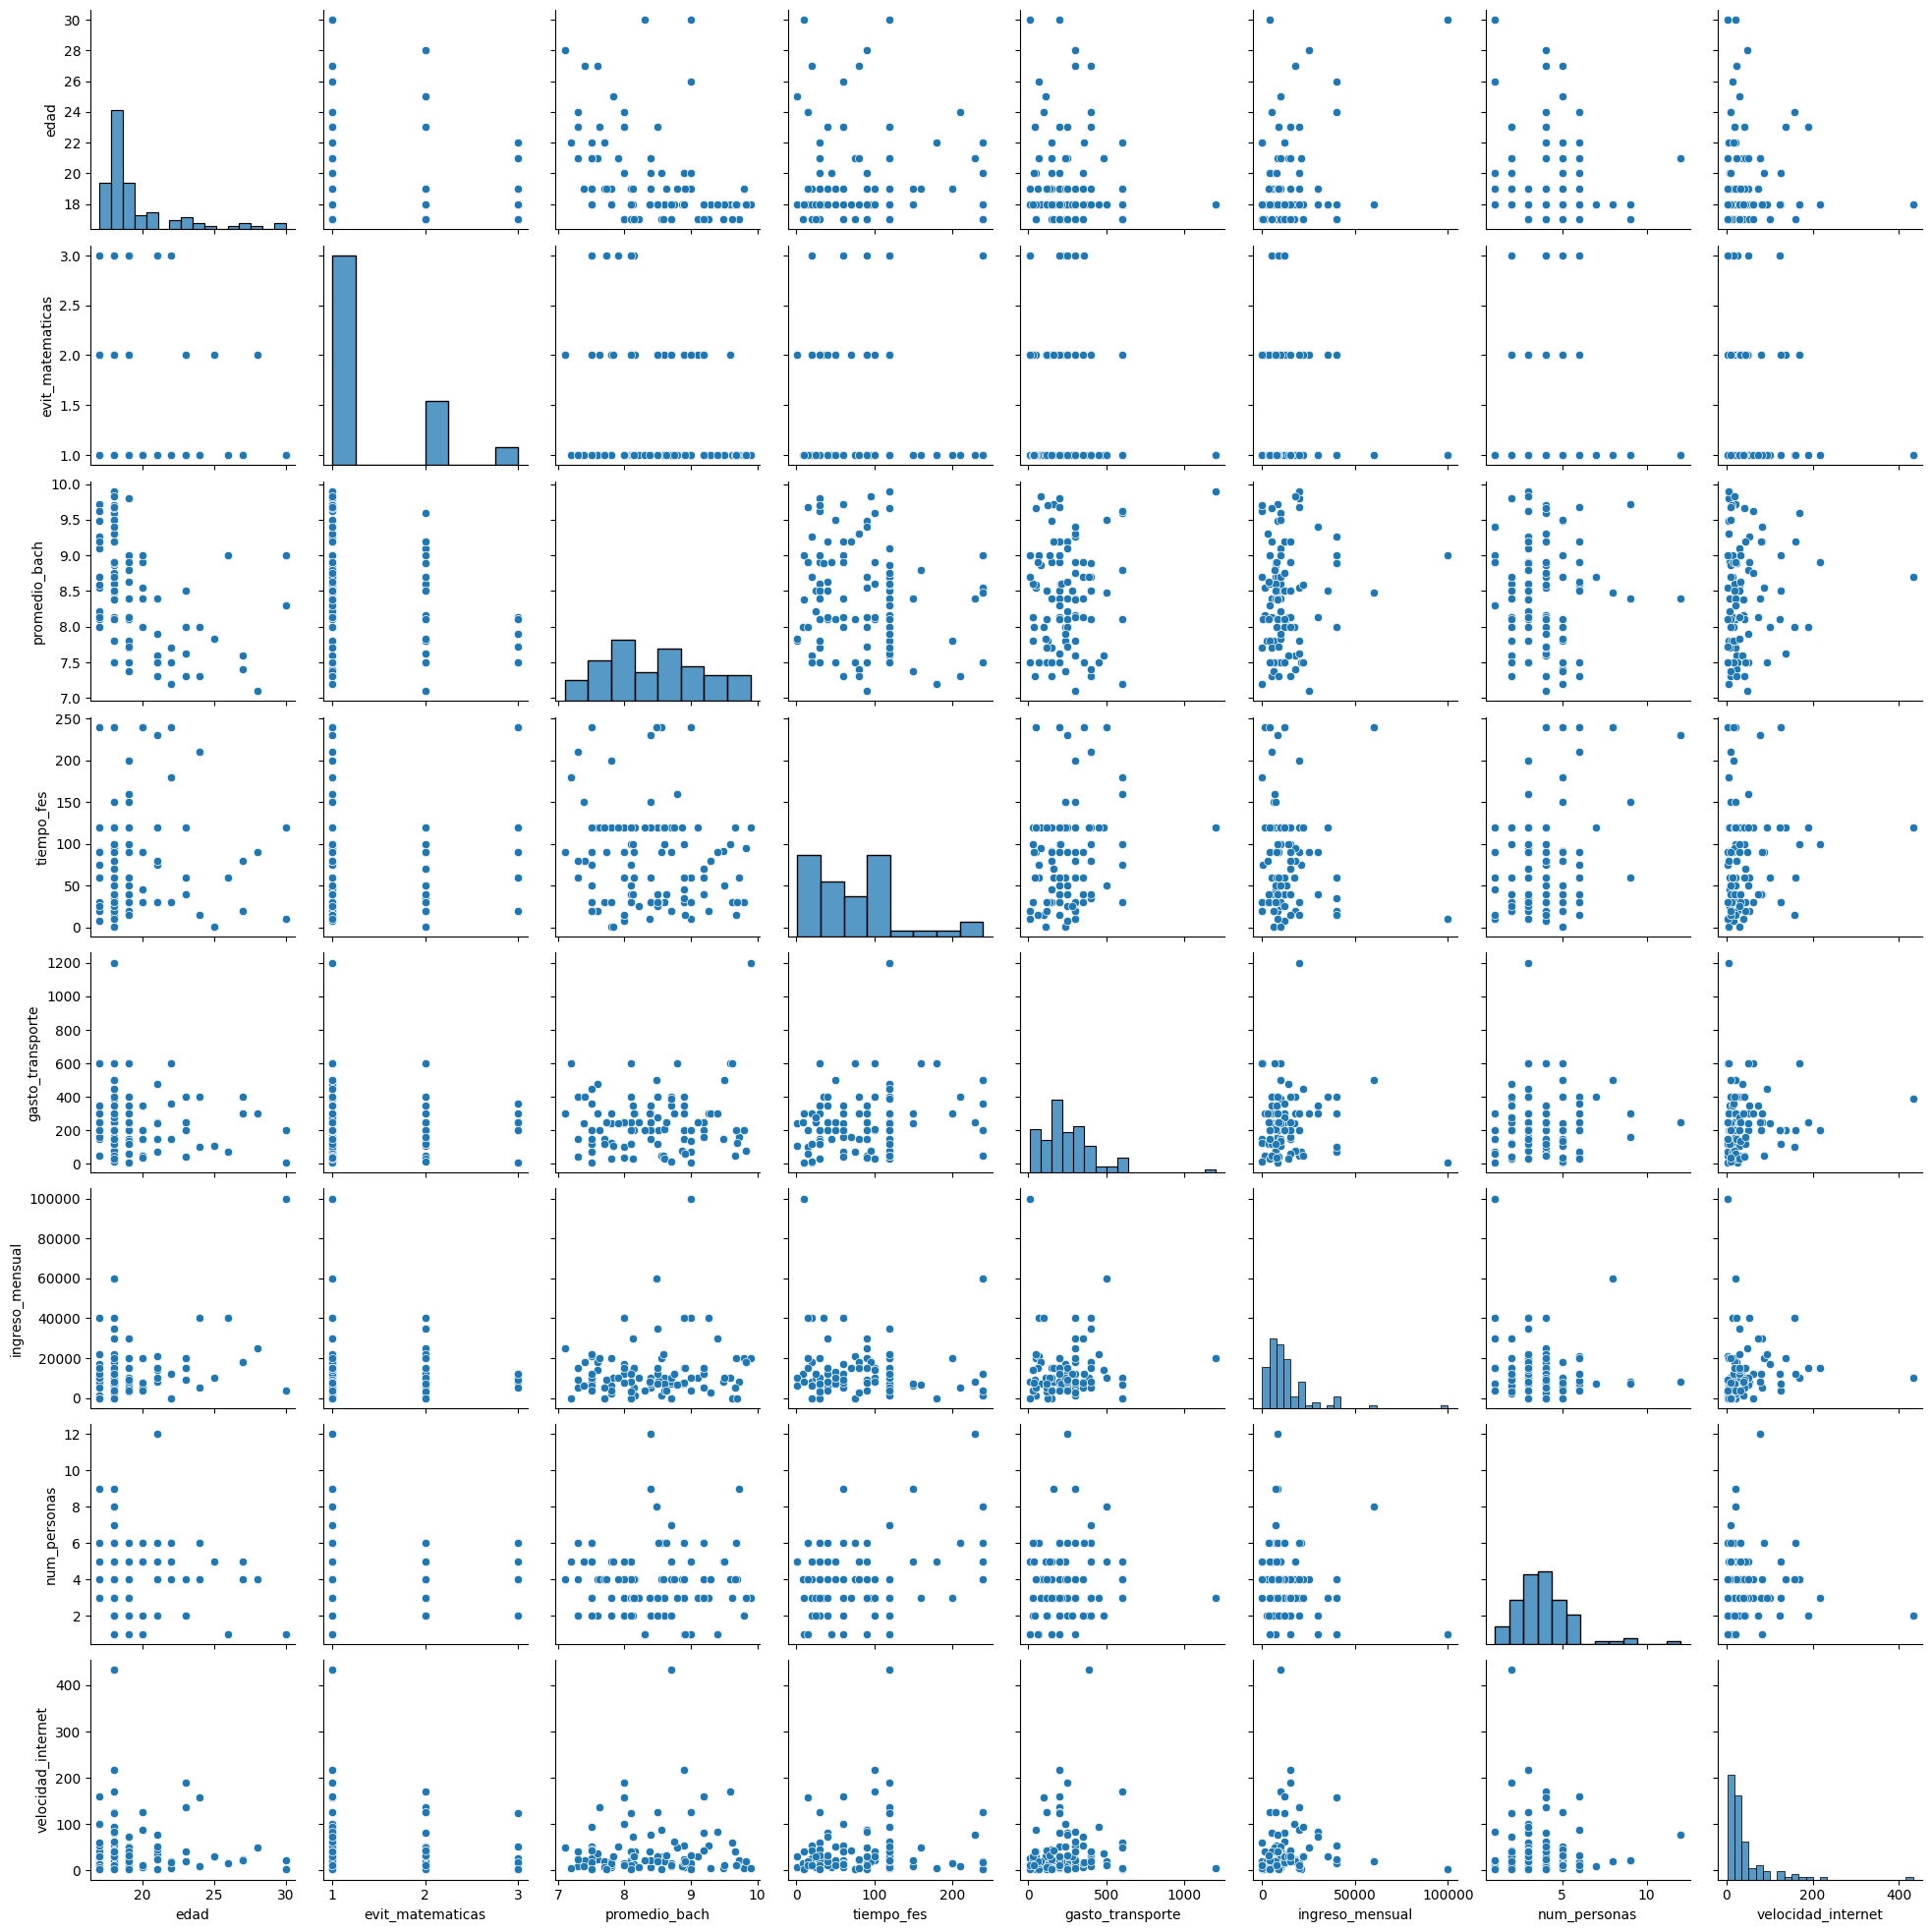

In [34]:
sns.pairplot(train[varc].sample(100))

In [35]:
vc = VarClusHi(df=train,feat_list=varc).varclus()

In [39]:
vc.rsquare

,Cluster,Variable,RS_Own,RS_NC,RS_Ratio
0,0,edad,0.68,0.03,0.33
1,0,promedio_bach,0.68,0.00,0.32
2,1,evit_matematicas,0.56,0.01,0.45
3,1,tiempo_fes,0.51,0.01,0.50
4,1,velocidad_internet,0.10,0.00,0.91
5,2,ingreso_mensual,0.55,0.01,0.45
6,2,num_personas,0.55,0.01,0.46
7,3,gasto_transporte,1.00,0.00,0.00


In [40]:
mc = list(vc.rsquare.sort_values(by=['Cluster','RS_Ratio']).groupby('Cluster').first()['Variable'])

In [41]:
mc

['promedio_bach', 'evit_matematicas', 'ingreso_mensual', 'gasto_transporte']

#### Distribución 

array([[<Axes: title={'center': 'promedio_bach'}>,
        <Axes: title={'center': 'evit_matematicas'}>],
       [<Axes: title={'center': 'ingreso_mensual'}>,
        <Axes: title={'center': 'gasto_transporte'}>]], dtype=object)

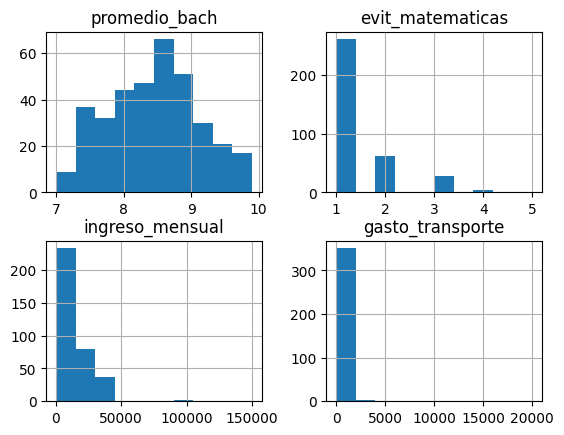

In [42]:
train[mc].hist()

#### Extremos 

In [43]:
for v,li,ls in train[mc].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values:
    train[f'ex_{v}'] = ((train[v]<li) | (train[v]>ls)).astype(int)
train['ex_'] = train.filter(like='ex_').max(axis=1) 
frequency_table(train, ['ex_'])

****Frequency Table  ex_  ***


     Abs. Freq.  Rel. Freq.  Cumm. Abs. Freq.  Cumm. Rel. Freq.
ex_                                                            
0           335        0.95               335              0.95
1            19        0.05               354              1.00






In [44]:
train = train[train['ex_']==0].reset_index(drop=True)
train.drop(train.filter(like='ex_').columns,axis=1,inplace=True)

array([[<Axes: title={'center': 'promedio_bach'}>,
        <Axes: title={'center': 'evit_matematicas'}>],
       [<Axes: title={'center': 'ingreso_mensual'}>,
        <Axes: title={'center': 'gasto_transporte'}>]], dtype=object)

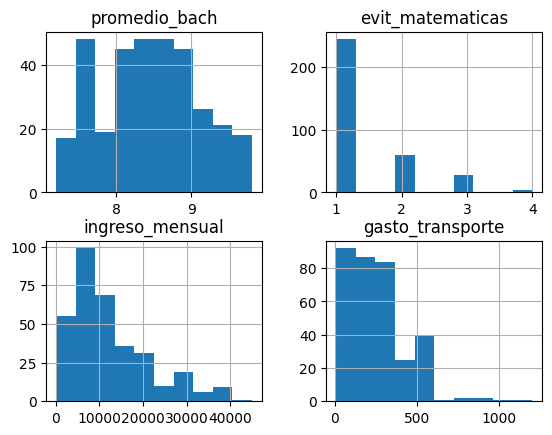

In [45]:
train[mc].hist()

## Pre-procesamiento

In [46]:
oh = OneHotEncoder(drop='if_binary',sparse_output=False)
oh.fit(train[vard])
train[oh.get_feature_names_out()] = oh.transform(train[vard])

In [47]:
varoh = oh.get_feature_names_out().tolist()

In [48]:
train = train[um+vart+varoh+mc]
train.head()

,ID,target,sexo_Mujer,situacion_sentimental_Tengo pareja,trabajas_Si,hijos_No,primera_opcion_carrera_Si,primera_opcion_fes_Sí,bachillerato_CCH,bachillerato_Otro,bachillerato_Prepa UNAM,sistema_operativo_Windows,promedio_bach,evit_matematicas,ingreso_mensual,gasto_transporte
0,A00000005,1,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,8.50,1,13000,150.00
1,A00000116,1,0.00,0.00,0.00,1.00,1.00,1.00,1.00,0.00,0.00,1.00,8.50,2,4000,195.00
2,A00000045,1,0.00,0.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,1.00,9.00,1,30000,240.00
3,A00000016,1,1.00,1.00,0.00,1.00,1.00,1.00,1.00,0.00,0.00,1.00,8.90,1,7000,300.00
4,A00000468,0,0.00,0.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,1.00,8.10,1,8000,400.00


## Aprendizaje 

### Híper-Parametrización

In [49]:
dt = DecisionTreeClassifier()

#### Espacio híper-paramétrico

In [50]:
param_grid = {
    'criterion': ["gini", "entropy", "log_loss"],
    'max_depth': np.arange(2,10),
    'min_samples_split': np.arange(0.05,0.1,0.01),
    'min_samples_leaf': np.arange(0.05,0.1,0.01),
    'max_features': ['sqrt', 'log2']+np.arange(2,10).tolist()
}

In [51]:
reduce(lambda x,y: x*y,[len(v) for v in param_grid.values()])

6000

#### Selección de híper parámetros 

##### Búsqueda Exhaustiva 

In [26]:
grid = GridSearchCV(estimator=dt,
                    param_grid=param_grid,
                    scoring='roc_auc',
                    cv=5,
                    n_jobs=-1,
                    verbose=1,
                    )

In [27]:
grid.fit(train[varoh+mc],train[vart])

Fitting 5 folds for each of 6000 candidates, totalling 30000 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9]),
                         'max_features': ['sqrt', 'log2', 2, 3, 4, 5, 6, 7, 8,
                                          9],
                         'min_samples_leaf': array([0.05, 0.06, 0.07, 0.08, 0.09]),
                         'min_samples_split': array([0.05, 0.06, 0.07, 0.08, 0.09])},
             scoring='roc_auc', verbose=1)

In [28]:
grid.best_params_

{'criterion': 'entropy',
 'max_depth': np.int64(7),
 'max_features': 4,
 'min_samples_leaf': np.float64(0.05),
 'min_samples_split': np.float64(0.09000000000000001)}

In [29]:
grid.best_score_

np.float64(0.8427471574185953)

In [32]:
dt = grid.best_estimator_
dt

DecisionTreeClassifier(criterion='entropy', max_depth=np.int64(7),
                       max_features=4, min_samples_leaf=np.float64(0.05),
                       min_samples_split=np.float64(0.09000000000000001))

##### Búsqueda aleatoria

In [52]:
grid = RandomizedSearchCV(estimator=dt,
                    param_distributions=param_grid,
                    n_iter=60,
                    scoring='roc_auc',
                    cv=5,
                    n_jobs=-1,
                    verbose=1,
                    )

In [53]:
grid.fit(train[varoh+mc],train[vart])

Fitting 5 folds for each of 60 candidates, totalling 300 fits


0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=60,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9]),
                                        'max_features': ['sqrt', 'log2', 2, 3,
                                                         4, 5, 6, 7, 8, 9],
                                        'min_samples_leaf': array([0.05, 0.06, 0.07, 0.08, 0.09]),
                                        'min_samples_split': array([0.05, 0.06, 0.07, 0.08, 0.09])},
                   scoring='roc_auc', verbose=1)

In [54]:
grid.best_params_,grid.best_score_

({'min_samples_split': np.float64(0.05),
  'min_samples_leaf': np.float64(0.08000000000000002),
  'max_features': 7,
  'max_depth': np.int64(4),
  'criterion': 'gini'},
 np.float64(0.8794836893294244))

In [55]:
dt = grid.best_estimator_

### Aprendizaje de parámetros 

In [56]:
dt.fit(train[varoh+mc],train[vart])

DecisionTreeClassifier(max_depth=np.int64(4), max_features=7,
                       min_samples_leaf=np.float64(0.08000000000000002),
                       min_samples_split=np.float64(0.05))

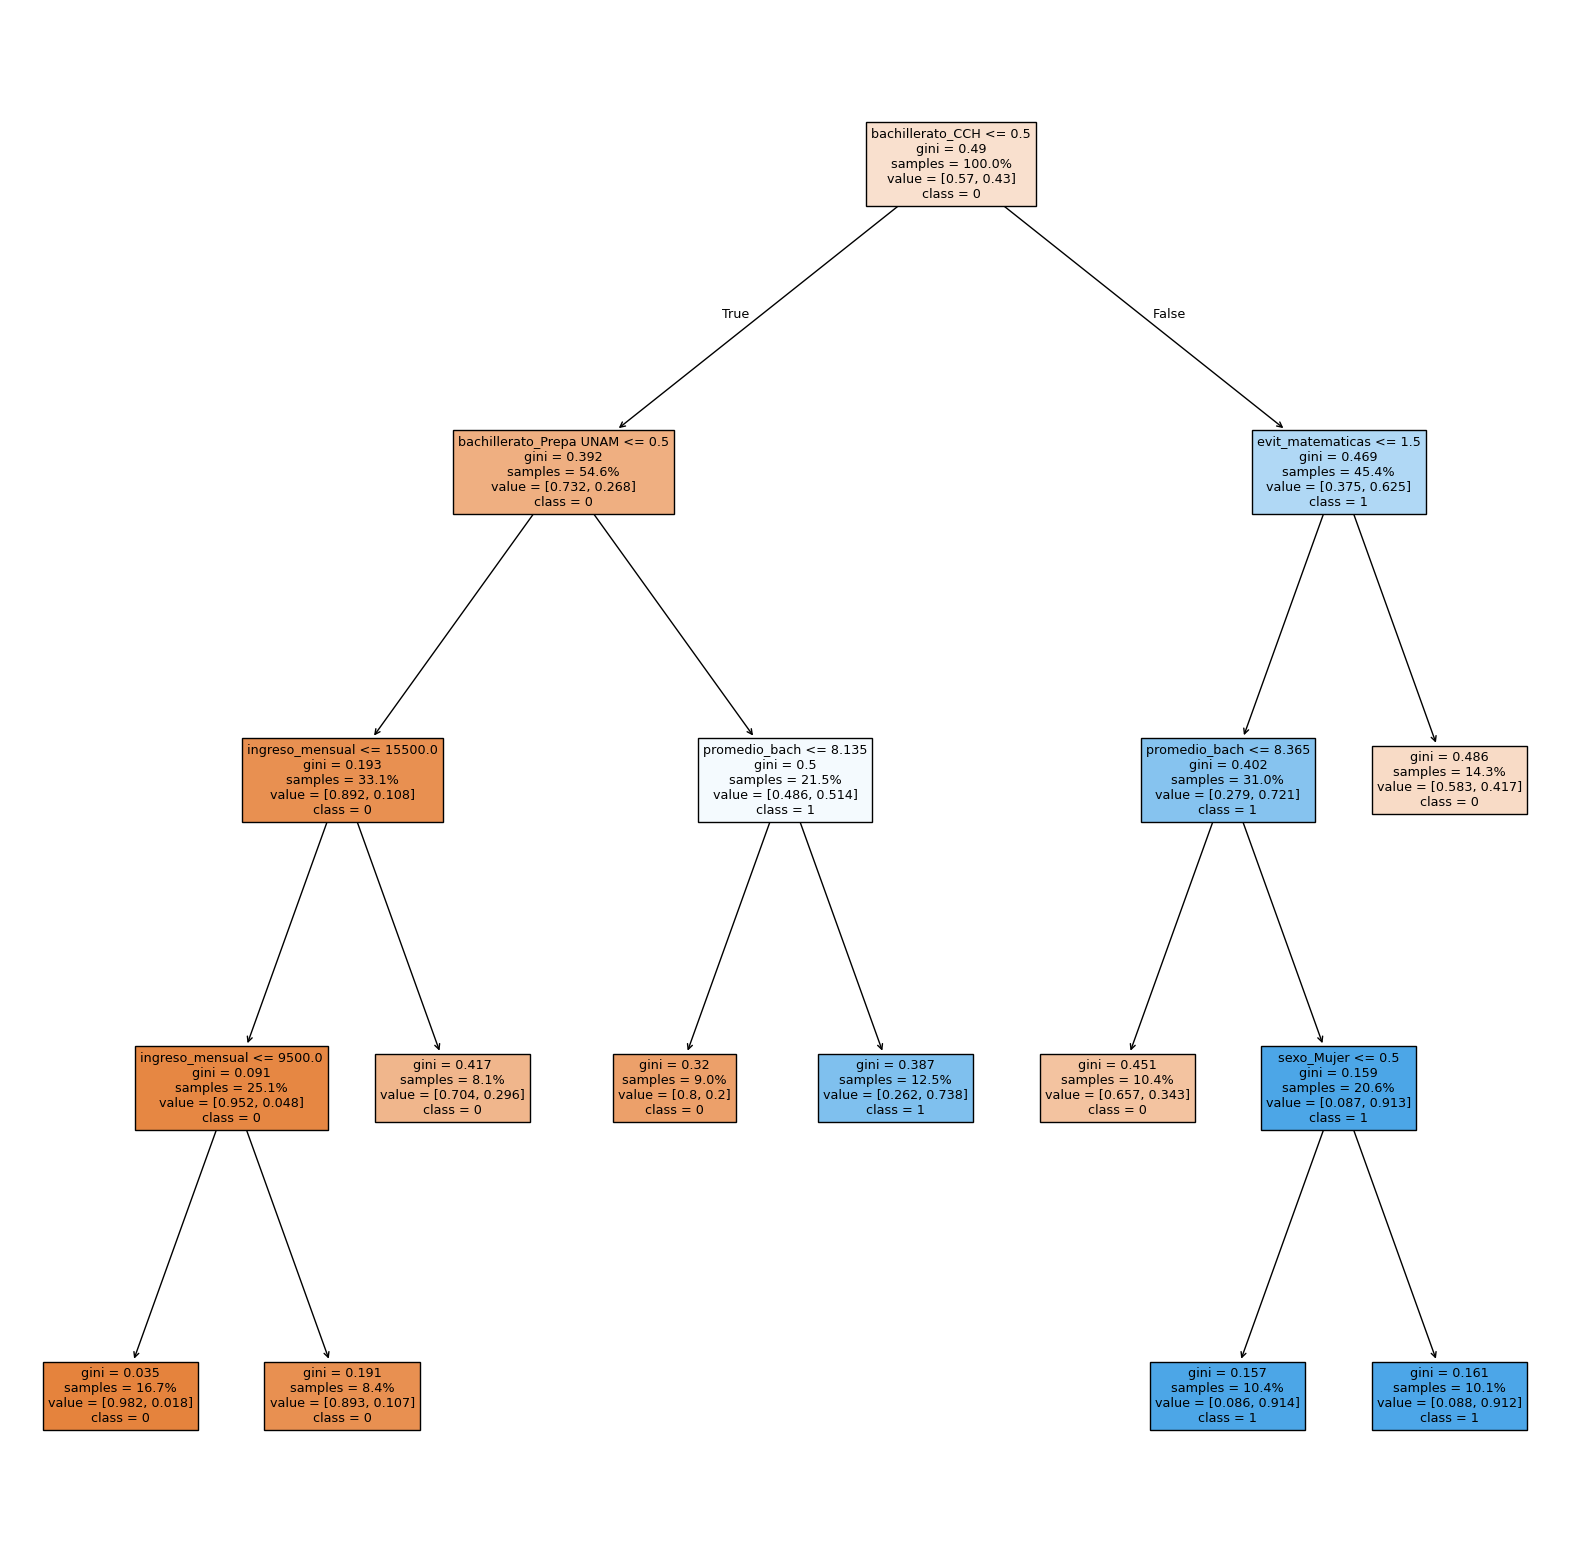

In [57]:
plt.figure(figsize=(20,20))
plot_tree(dt, feature_names=varoh + mc, class_names=['0', '1'], filled=True, proportion=True, label='all')
plt.show()

## Validación del modelo

In [59]:
valid[vard] = dn.transform(valid[vard])
valid[oh.get_feature_names_out()] = oh.transform(valid[vard])

/Users/josegustavofuentescabrera/Documents/anahuac/aprendizaje_supervisado/.venv/lib/python3.11/site-packages/CreditScoringToolkit/DiscreteNormalizer.py:114: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/Users/josegustavofuentescabrera/Documents/anahuac/aprendizaje_supervisado/.venv/lib/python3.11/site-packages/CreditScoringToolkit/DiscreteNormalizer.py:114: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0.

In [60]:
print("train",roc_auc_score(y_true=train[vart],
              y_score=dt.predict_proba(train[varoh+mc])[:,1]))
print("valid",roc_auc_score(y_true=valid[vart],
                y_score=dt.predict_proba(valid[varoh+mc])[:,1]))

train 0.8694735311227457
valid 0.79359243697479


## Uso del modelo 

In [48]:
train['node'] = dt.apply(train[varoh + mc])
train.head()

,ID,TARGET,C_IP_b'Yes',C_VMP_b'Yes',V_T_DAY_CHG,V_CS_CALLS,V_T_EVE_CALLS,V_T_INT_CHG,node
0,912.0,1.0,0.0,0.0,45.53,5.0,121.0,3.89,18
1,1478.0,0.0,0.0,0.0,28.66,1.0,117.0,2.65,10
2,1795.0,1.0,0.0,0.0,48.72,1.0,108.0,3.11,17
3,2286.0,0.0,0.0,0.0,26.59,1.0,98.0,3.19,6
4,2265.0,0.0,0.0,0.0,33.49,3.0,107.0,2.35,10


In [50]:
valid['node'] = dt.apply(valid[varoh + mc])

In [56]:
pd.concat([train[['node']+vart+um].groupby(['node']+vart).count().reset_index().assign(muestra='ent'),
valid[['node']+vart+um].groupby(['node']+vart).count().reset_index().assign(muestra='val')],ignore_index=True).to_clipboard(index=False)